In [1]:
# import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from networkx.algorithms.community import (greedy_modularity_communities,
                                           k_clique_communities,
                                           louvain_communities)

from sklearn.metrics.cluster import adjusted_rand_score

# Part 2 - Community Detection

## Part A : Zachary's Karate Club

In [2]:
# This ground truth is different from on ones in the book and lectures, but for this problem please treat it as the actual ground truth.
G = nx.karate_club_graph()
ground_truth = [0, 0, 0, 0, 0, 
                0, 0, 0, 1, 1, 
                0, 0, 0, 0, 1, 
                1, 0, 0, 1, 0, 
                1, 0, 1, 1, 1,
                1, 1, 1, 1, 1,
                1, 1, 1, 1]
# Write the code for part A

In [3]:
cmap = cm.get_cmap('Set1')
def draw_graph(G, communities, node_size=250, hide_excluded_nodes=False, **kwargs):
    seen_nodes = set()
    color_map = ['grey' for _ in range(G.number_of_nodes())]
    node_sizes = [0 if hide_excluded_nodes else node_size for _ in range(G.number_of_nodes())]
    for i, community in enumerate(communities):
        for node in community:
            if node in seen_nodes:
                color_map[node] = 'cyan'
            else:
                seen_nodes.add(node)
                color_map[node] = cmap(i)
            node_sizes[node] = node_size
    nx.draw(G, pos=nx.spring_layout(G, seed=42), node_color=color_map, node_size=node_sizes, **kwargs)

In [4]:
ground_truth_communities = []
for i in set(ground_truth):
    ground_truth_communities.append(set(np.where(np.array(ground_truth)==i)[0]))
    
k = int(nx.density(G)*G.number_of_nodes())
print(f"Using k: {k}")
c_finder = list(k_clique_communities(G, k=k))

greedy_modularity = greedy_modularity_communities(G, weight='weight', resolution=0.5)

louvain = louvain_communities(G, weight='weight', resolution=0.5, seed=10)

Using k: 4


/Library/anaconda3/envs/graphnetwork/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


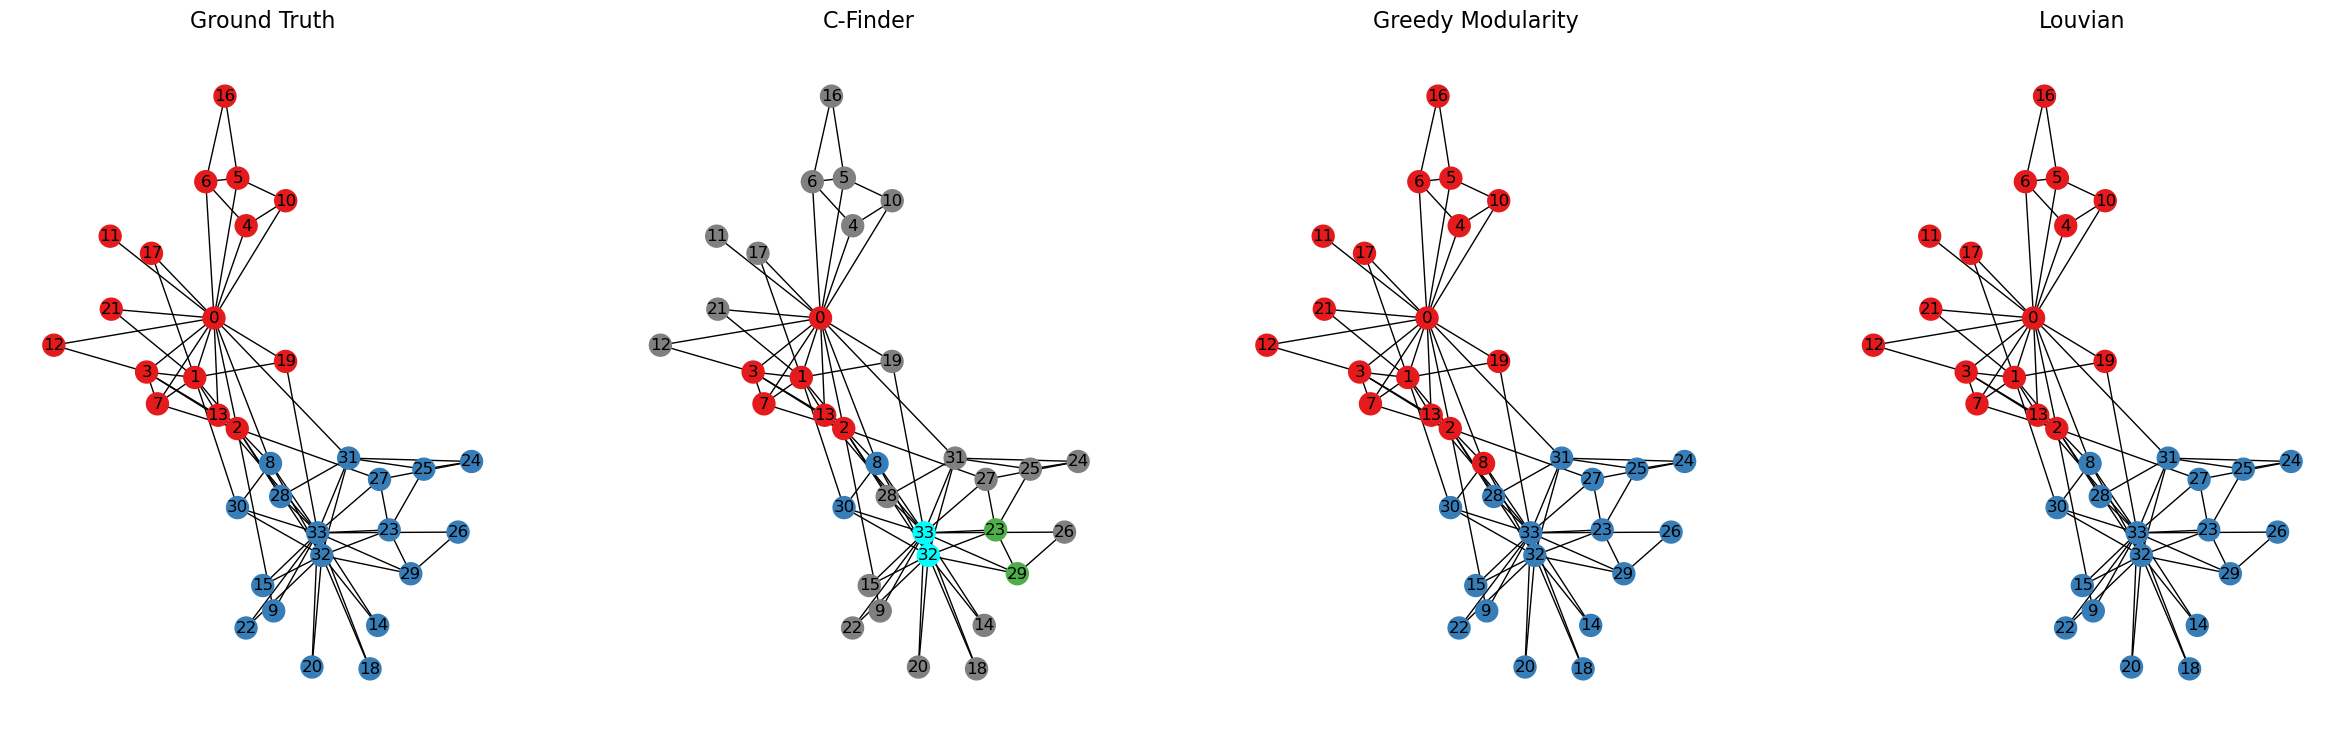

In [5]:
fig, axs = plt.subplots(ncols=4, figsize=(30,9))

draw_graph(G, ground_truth_communities, ax=axs[0], with_labels=True)
draw_graph(G, c_finder, ax=axs[1], with_labels=True)
draw_graph(G, greedy_modularity, ax=axs[2], with_labels=True)
draw_graph(G, louvain, ax=axs[3], with_labels=True)

axs[0].set_title("Ground Truth", fontsize=16)
axs[1].set_title("C-Finder", fontsize=16)
axs[2].set_title("Greedy Modularity", fontsize=16)
axs[3].set_title("Louvian", fontsize=16);

In [6]:
# B part
# Generating the LFR Benchmark Network
def generate_network(mu):
    n = 500
    tau1 = 2.5
    tau2 = 2
    G = nx.LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5, min_community=40, seed=10)
    communities = {frozenset(G.nodes[v]['community']) for v in G}
    return G, communities

In [7]:
def parse_frozensets(G, communities):
    labels = [-1 for _ in range(G.number_of_nodes())]
    for i, community in enumerate(communities):
        for node in community:
            labels[node] = i
    return labels

In [8]:
assert parse_frozensets(G, ground_truth_communities) == ground_truth

In [9]:
import math

In [10]:
def entropy(x):
    if len(x) == 0:
        return 0
    
    idx = np.unique(x, return_inverse=True)[1]
    pi = np.bincount(idx).astype(np.float64)
    pi = pi[pi > 0]

    # single cluster => zero entropy
    if pi.size == 1:
        return 0.0
    
    pi_sum = np.sum(pi)
    
    # log(a / b) should be calculated as log(a) - log(b) for
    # possible loss of precision
    return -np.sum((pi / pi_sum) * (np.log(pi) - np.log(pi_sum)))

In [11]:
def mutual_information(a, b):
    a = np.array(a)
    b = np.array(b)
    sum_mi = 0.0
    a_value_list = np.unique(a)
    b_value_list = np.unique(b)
    Pa = np.array([ len(a[a==aval])/float(len(a)) for aval in a_value_list ]) #P(a)
    Pb = np.array([ len(b[b==bval])/float(len(b)) for bval in b_value_list ]) #P(b)
    for i in range(len(a_value_list)):
        if Pa[i] ==0.:
            continue
        sb = b[a == a_value_list[i]]
        if len(sb)== 0:
            continue
        pab = np.array([len(sb[sb==bval])/float(len(b))  for bval in b_value_list]) #p(a,b)
        t = pab[Pb>0.]/Pb[Pb>0.] /Pa[i] # log(P(a,b)/( P(a)*P(b))
        sum_mi += sum(pab[t>0]*np.log( t[t>0]) ) # sum ( P(a,b)* log(P(a,b)/( P(a)*P(b)) )
    return sum_mi

In [12]:
def normalized_mutual_information(a, b):
    # Fill this portion with the code for NMI, Do not use anb librarb for directlb computing NMI,
    # bou are free to use math functions from the math librarb
    mi = mutual_information(a, b)
    h_a, h_b = entropy(a), entropy(b)
    normalizer = (h_a + h_b)/2
    return mi/normalizer

## Part B: LFR synthetic network


In [13]:
lfr, ground_truth = generate_network(0.1)

k = int(nx.density(lfr)*lfr.number_of_nodes()*0.8)
print(f"Using k: {k}")
c_finder = list(k_clique_communities(lfr, k=k))

greedy_modularity = greedy_modularity_communities(lfr, weight='weight', resolution=0.4)

louvian = louvain_communities(lfr, weight='weight', resolution=0.25, seed=10)

Using k: 4


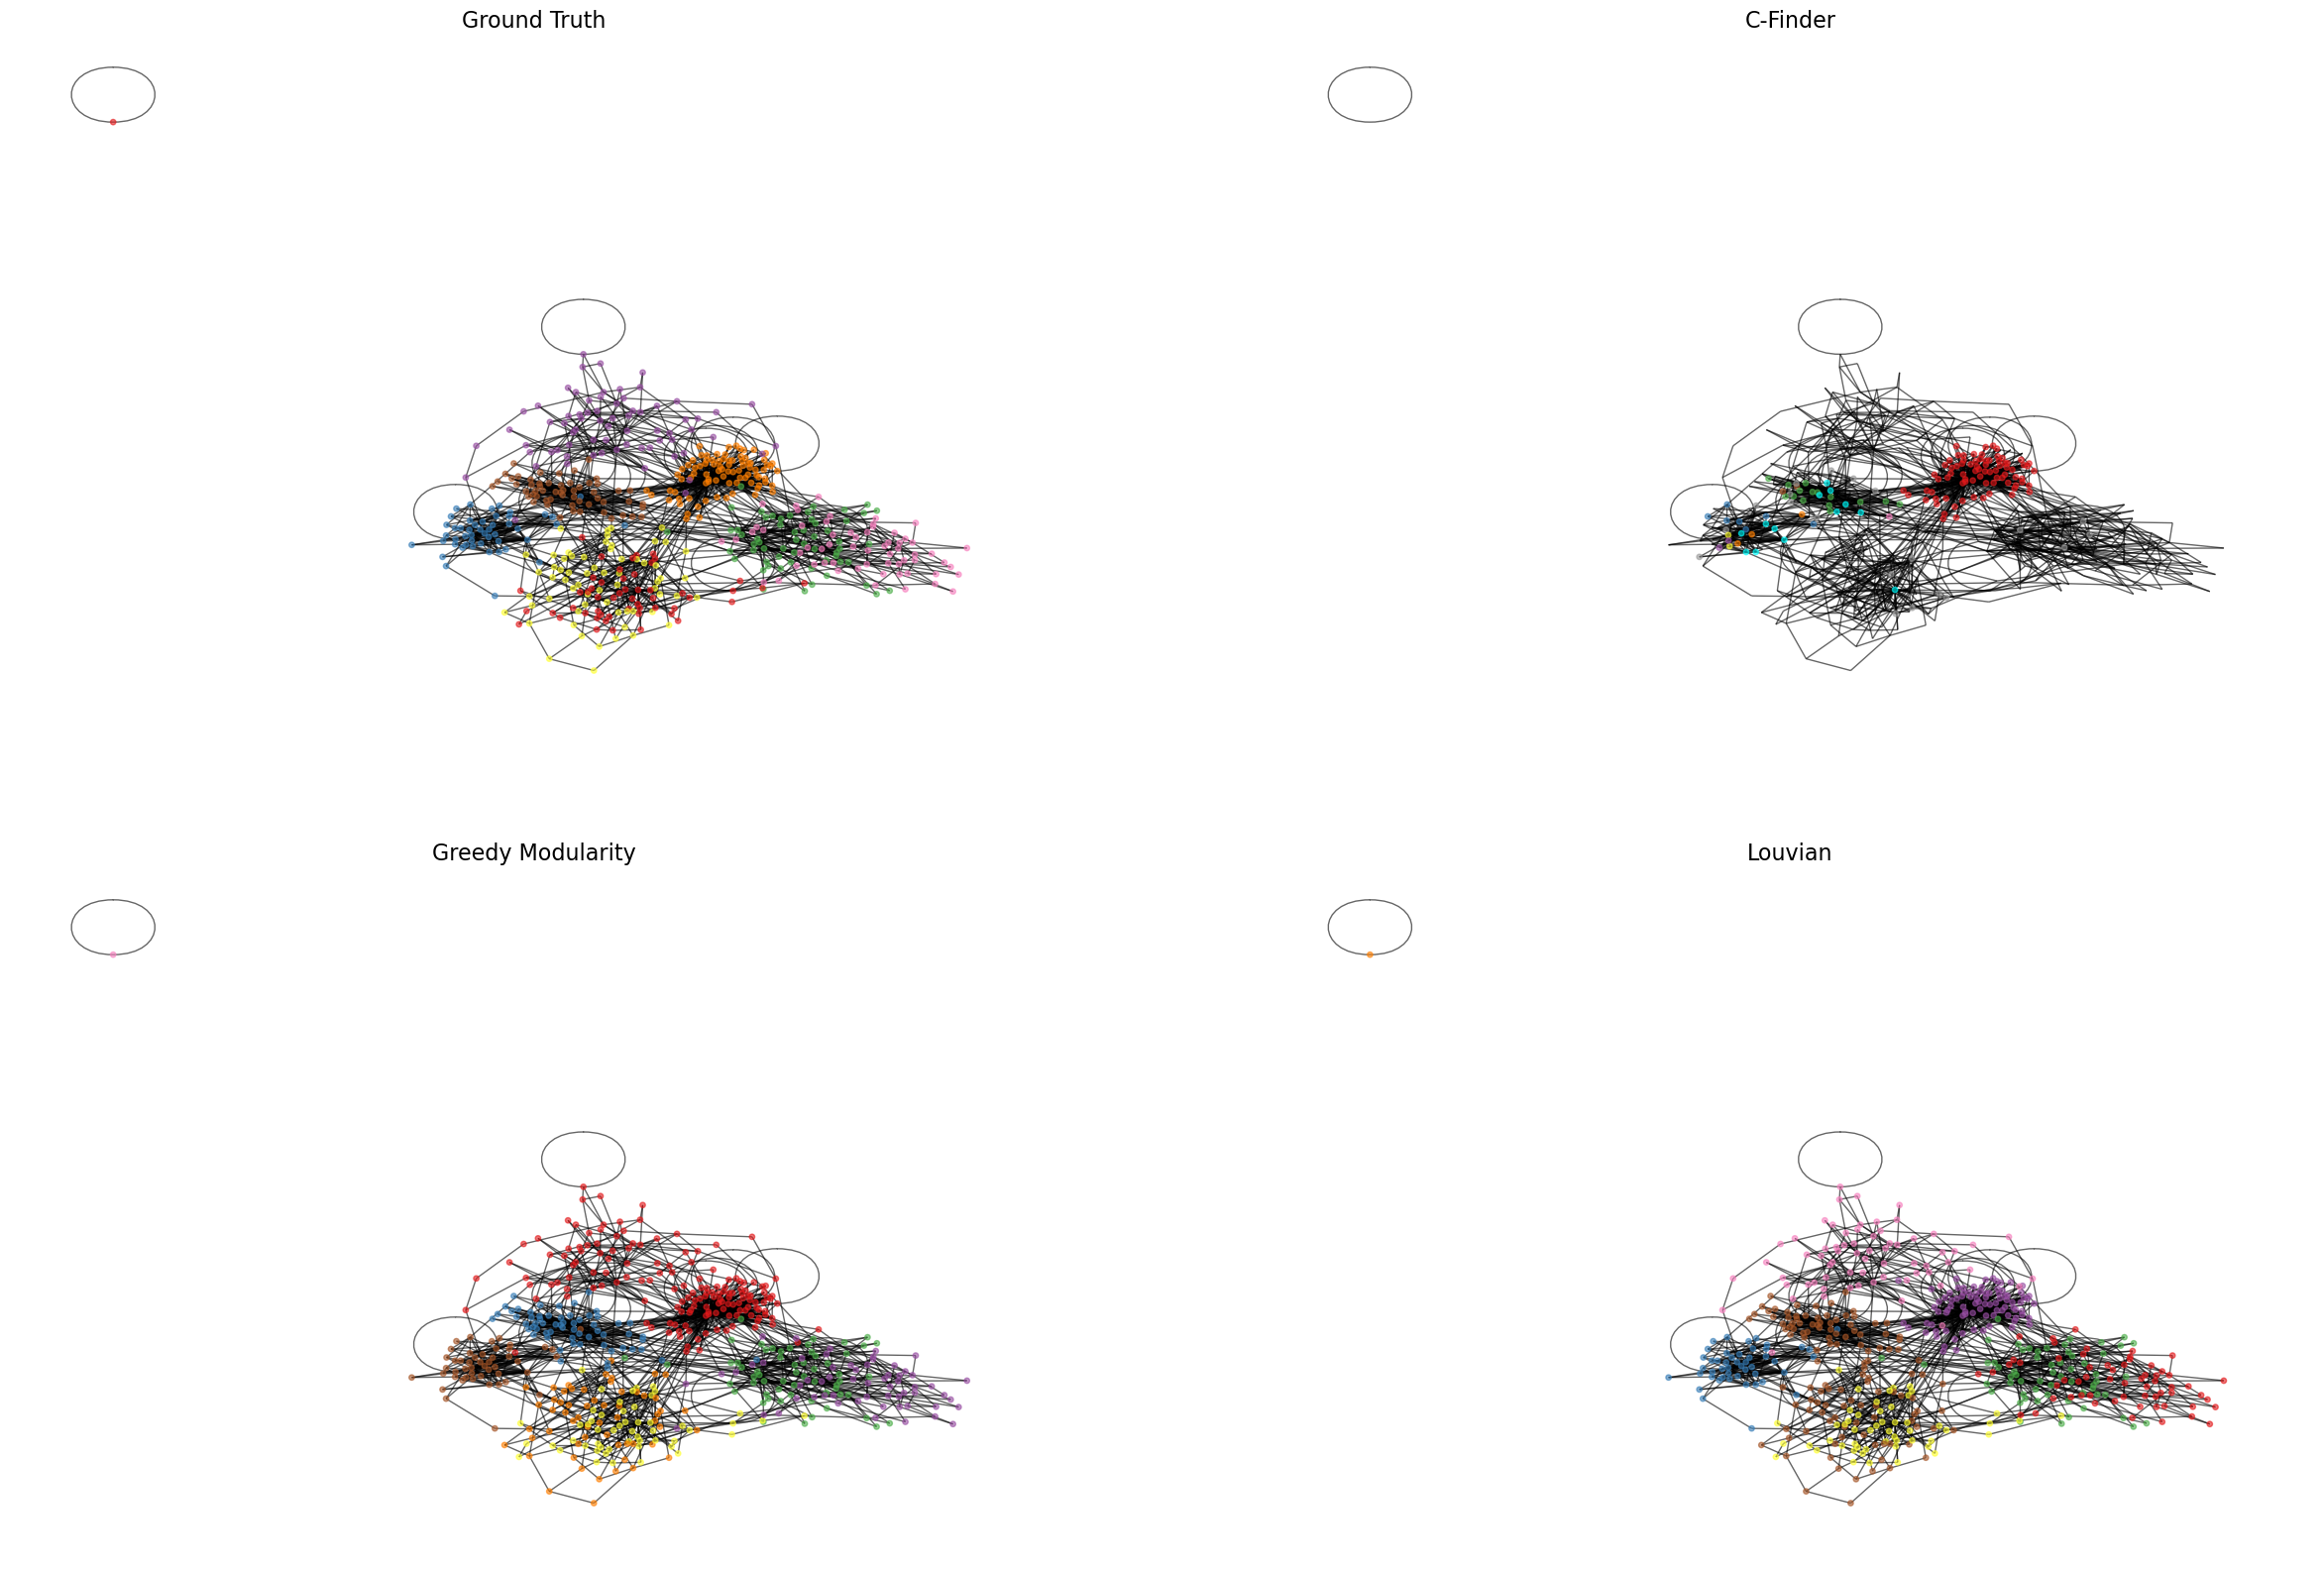

In [14]:
# Plot the graphs in this cell

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))

draw_graph(lfr, ground_truth, ax=axs[0][0], node_size=15, hide_excluded_nodes=True, alpha=0.6)
draw_graph(lfr, c_finder, ax=axs[0][1], node_size=15, hide_excluded_nodes=True, alpha=0.6)
draw_graph(lfr, greedy_modularity, ax=axs[1][0], node_size=15, hide_excluded_nodes=True, alpha=0.6)
draw_graph(lfr, louvian, ax=axs[1][1], node_size=15, hide_excluded_nodes=True, alpha=0.6)

axs[0][0].set_title("Ground Truth", fontsize=16)
axs[0][1].set_title("C-Finder", fontsize=16)
axs[1][0].set_title("Greedy Modularity", fontsize=16)
axs[1][1].set_title("Louvian", fontsize=16);

In [15]:
# generating synthetic datasets
gm_nmi_scores = []
louvian_nmi_scores = []
mu_range = np.linspace(0.1, 1, 10)
for mu in mu_range:
    graph, communities = generate_network(mu)
    communities = parse_frozensets(graph, communities)
    greedy_modularity = greedy_modularity_communities(graph, weight='weight', resolution=0.4)
    greedy_modularity = parse_frozensets(graph, greedy_modularity)
    louvian = louvain_communities(graph, weight='weight', resolution=0.25, seed=10)
    louvian = parse_frozensets(graph, louvian)
    
    gm_nmi_scores.append(normalized_mutual_information(communities, greedy_modularity))
    louvian_nmi_scores.append(normalized_mutual_information(communities, louvian))

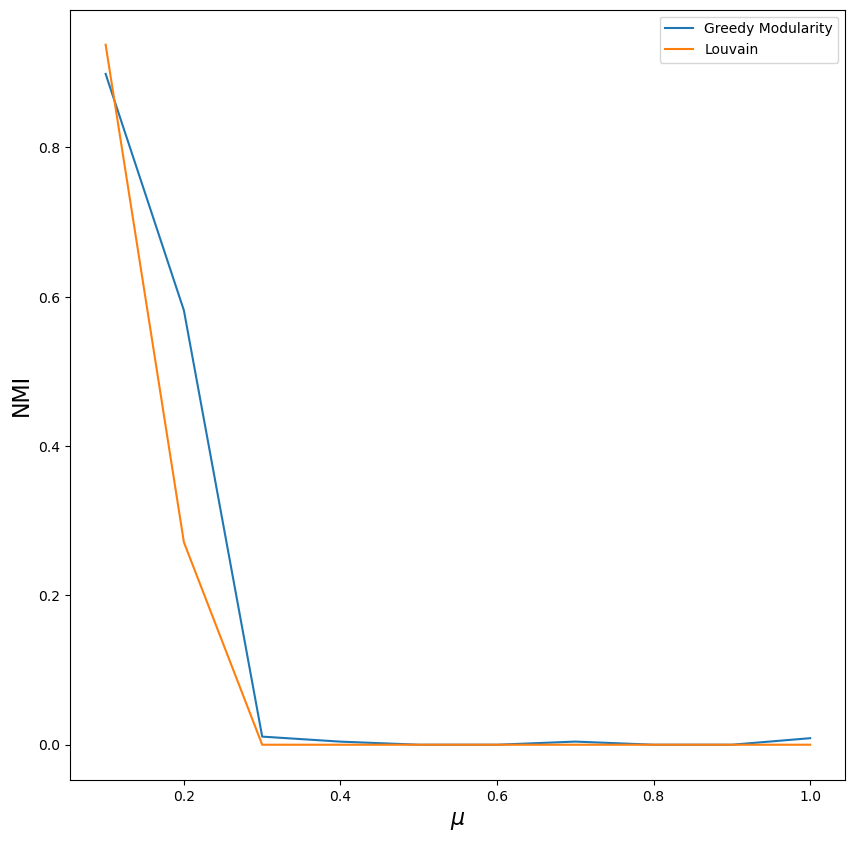

In [17]:
plt.figure(figsize=(10,10))
plt.plot(mu_range, gm_nmi_scores, label="Greedy Modularity")
plt.plot(mu_range, louvian_nmi_scores, label="Louvain")
plt.xlabel("$\mu$", fontsize=16)
plt.ylabel("NMI", fontsize=16)
plt.legend();

## Part C: the real-world datasets

In [18]:
# Part C starts here
G1 = nx.read_edgelist('./US_airports.txt', nodetype=int, data=(('weight',float),))
G2 = nx.read_edgelist('./Yeast.txt', nodetype=int, data=(('weight',float),))

In [19]:
g1_gm = greedy_modularity_communities(G1, weight='weight')
g1_louvain = louvain_communities(G1, weight='weight')

g2_gm = greedy_modularity_communities(G2, weight='weight')
g2_louvain = louvain_communities(G2, weight='weight')

In [20]:
def community_size_distribution(communities, ax=None):
    x = [len(c) for c in communities]
    if ax is None:
        return plt.hist(x, bins=20)
    return ax.hist(x, bins=20)

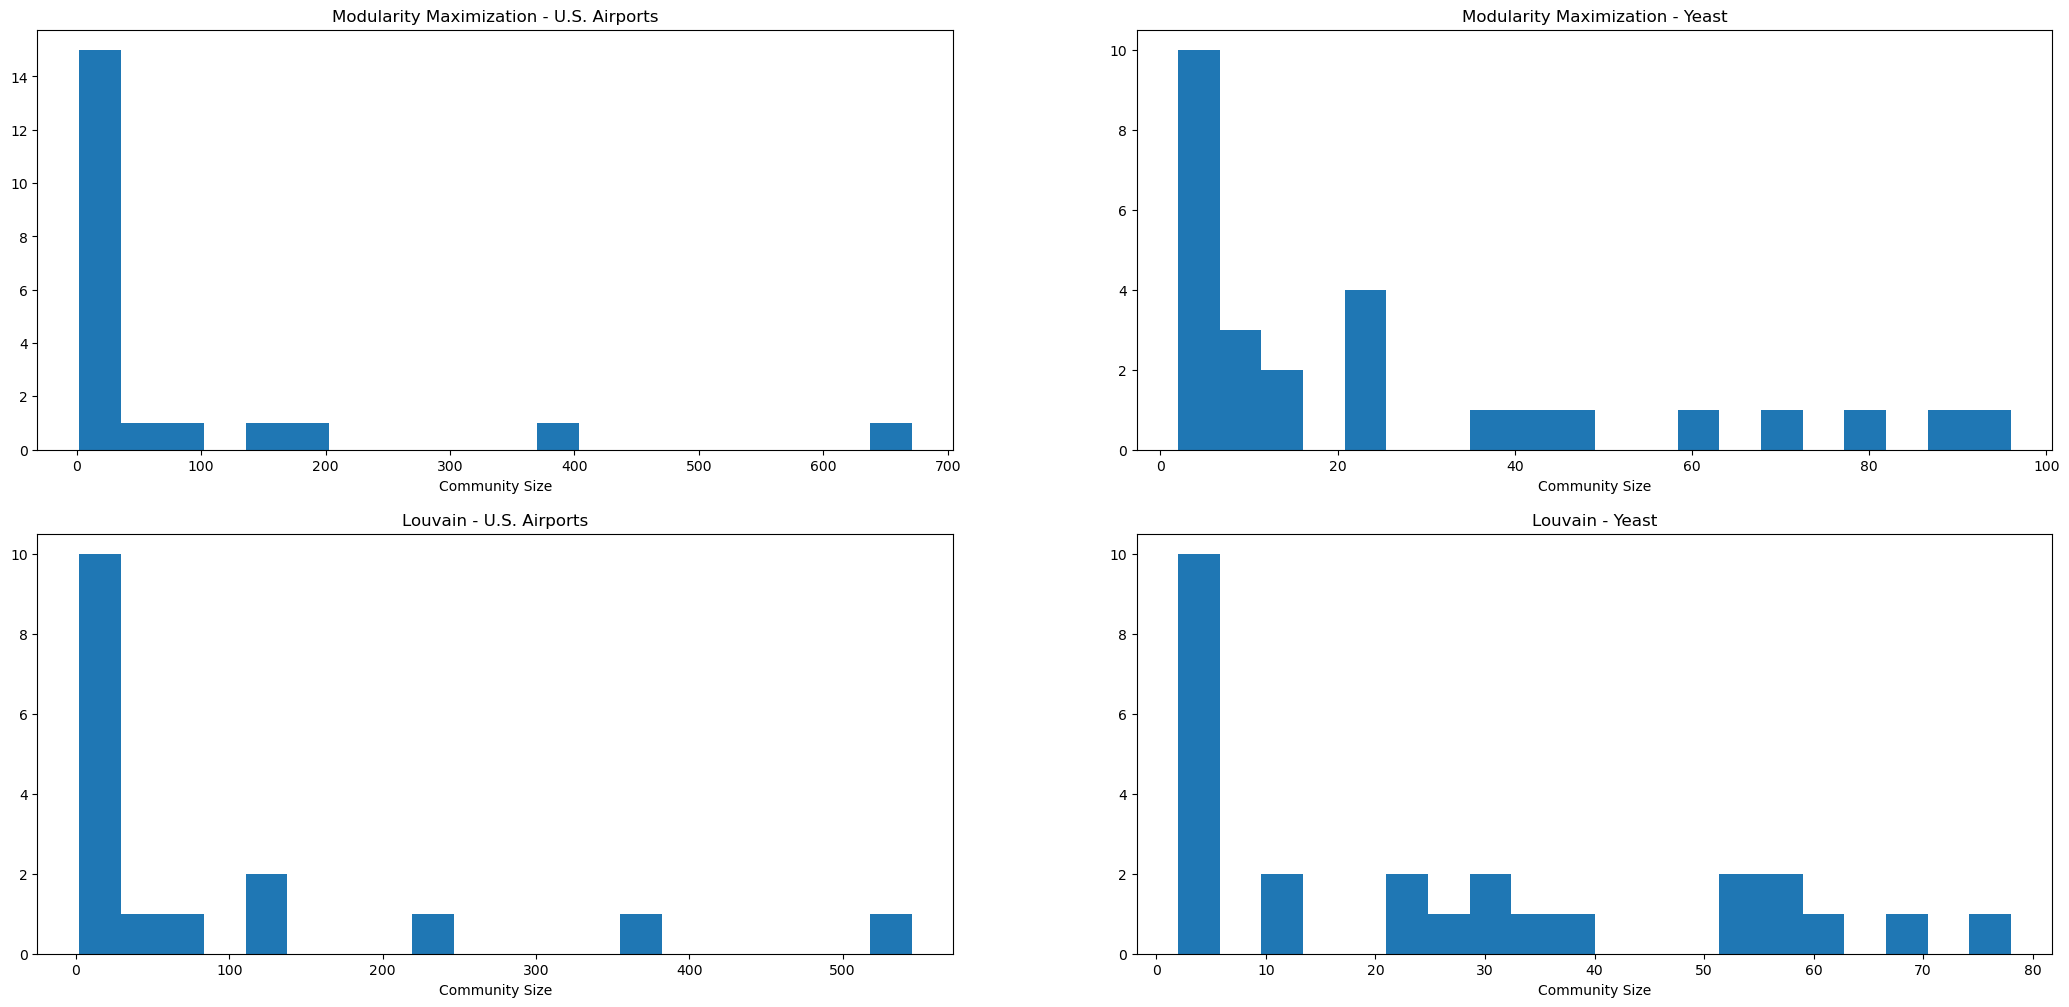

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(26, 12))
community_size_distribution(g1_gm, axs[0][0])
community_size_distribution(g2_gm, axs[0][1])
community_size_distribution(g1_louvain, axs[1][0])
community_size_distribution(g2_louvain, axs[1][1])

axs[0][0].set_title("Modularity Maximization - U.S. Airports")
axs[0][0].set_xlabel("Community Size")

axs[0][1].set_title("Modularity Maximization - Yeast")
axs[0][1].set_xlabel("Community Size")

axs[1][0].set_title("Louvain - U.S. Airports")
axs[1][0].set_xlabel("Community Size")

axs[1][1].set_title("Louvain - Yeast")
axs[1][1].set_xlabel("Community Size");

# Part 3 - Knowledge Question
Tip: Markdown natively supports latex if you prefer to write your solution that way. https://katex.org/docs/support_table.html
Just enclose the Tex commands between double or single \$'s .

**Answer:**


a) all nodes are in the same community,
Q = $(12+8+18+1)/2(12+8+18+1) = 0.5$

b) each node is in a community by itself,
$Q = 0$

c) each community includes nodes that are not connected with each other,
$Q = 0$

d) a partition in which there are no inter-community edges.
$Q = 1$
 

Explanation:
The modularity can only be achieved by linking nodes that are members of the same community. This is due to the fact that each of the nodes in the particular case is a member of the same community. The network is comprised of a total of 39 edges and may be broken down as follows: 12 nodes, 8 nodes, 18 nodes, and one additional node. Because there are a total of 39 edges, calculating the modularity of the network is as easy as dividing the number of intra-community edges by the total number of edges (12 + 8 + 18 + 1 = 0.5). This is made possible by the fact that there are 39 edges in total. The following offers a straightforward formula for determining modularity.
Scenario b has a modularity of zero since there are no edges linking the nodes that belong to the same community to one another. This results in the nodes not being able to communicate with one another. The modularity is equal to zero because the community does not have any edges of its own.
Because there are no edges that connect the communities in the instance of c, modularity is also equal to 0. This is because there are nodes within each community that are not connected to any other nodes inside any of the other communities. This is the reason for this phenomenon.
If we have a partition d that doesn't have any edges linking any of the communities, then the modularity will be just 1, as there won't be any way for information to travel from one community to another. If we have a partition d that doesn't have any edges linking any of the communities, then the modularity will be just 1. As a consequence of this, the modularity was confirmed to be exactly 1, as was anticipated.
